In [38]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix


from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, precision_recall_curve, classification_report
import joblib

# Make sure "scripts" is in your Python path so you can import from scripts/preprocessing.py
sys.path.append('scripts')

# Import your functions and feature list
from preprocessing import preprocess, selected_features


In [39]:
def plot_roc(y_true, y_proba, title='ROC Curve'):
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(5,4))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
    plt.plot([0,1], [0,1],'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

def plot_conf_matrix(y_true, y_pred, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()


In [40]:
# --- Data Preprocessing ---
DATA_PATH = "data/raw/HR_Attrition_Dataset.csv"

# CALL YOUR FUNCTION (assumes returns train/val/test splits in same order as before)
X_train, X_val, X_test, y_train, y_val, y_test = preprocess(data_path=DATA_PATH)


In [41]:
# Set up StratifiedKFold
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Expanded hyperparameter grid with class_weight tuning
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'liblinear'],
    'class_weight': [None, 'balanced', {0: 1, 1: 2}, {0: 1, 1: 3}, {0: 1, 1: 5}]
}

# Base classifier (no class_weight here, let grid search tune it)
clf = LogisticRegression(max_iter=1000, random_state=42)

# GridSearchCV with F1 scoring
grid_search = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    scoring='f1',
    cv=skf,
    verbose=2,
    n_jobs=-1
)

# Fit model
grid_search.fit(X_train, y_train)
print("\nBest Parameters:", grid_search.best_params_)
print("Best F1 Score (CV):", grid_search.best_score_)

# Best estimator
best_logreg = grid_search.best_estimator_


Fitting 5 folds for each of 50 candidates, totalling 250 fits

Best Parameters: {'C': 0.1, 'class_weight': {0: 1, 1: 2}, 'penalty': 'l2', 'solver': 'lbfgs'}
Best F1 Score (CV): 0.5254285714285715


In [42]:
# --- Get Cross-Validation Results ---
cv_results = pd.DataFrame(grid_search.cv_results_)
leaderboard = cv_results.loc[:, ['params', 'mean_test_score', 'std_test_score']]
leaderboard = leaderboard.rename(columns={'mean_test_score': 'mean_F1', 'std_test_score': 'std_F1'})
leaderboard = leaderboard.sort_values(by="mean_F1", ascending=False)
print("\nTop 10 Hyperparameter Combinations:")
print(leaderboard.head(10))


Top 10 Hyperparameter Combinations:
                                               params   mean_F1    std_F1
14  {'C': 0.1, 'class_weight': {0: 1, 1: 2}, 'pena...  0.525429  0.043203
45  {'C': 100, 'class_weight': {0: 1, 1: 2}, 'pena...  0.520453  0.044337
34  {'C': 10, 'class_weight': {0: 1, 1: 2}, 'penal...  0.520453  0.044337
35  {'C': 10, 'class_weight': {0: 1, 1: 2}, 'penal...  0.520453  0.044337
44  {'C': 100, 'class_weight': {0: 1, 1: 2}, 'pena...  0.520453  0.044337
24  {'C': 1, 'class_weight': {0: 1, 1: 2}, 'penalt...  0.513588  0.044207
25  {'C': 1, 'class_weight': {0: 1, 1: 2}, 'penalt...  0.513588  0.044207
47  {'C': 100, 'class_weight': {0: 1, 1: 3}, 'pena...  0.511523  0.052599
46  {'C': 100, 'class_weight': {0: 1, 1: 3}, 'pena...  0.511523  0.052599
37  {'C': 10, 'class_weight': {0: 1, 1: 3}, 'penal...  0.511523  0.052599


In [43]:
# ============================================================
# THRESHOLD OPTIMIZATION - DUAL STRATEGY
# 1. F1-Optimized: Best balance between precision and recall
# 2. Recall-Optimized: Minimize surprise departures
# ============================================================

from sklearn.metrics import precision_recall_curve

# Get predicted probabilities on validation set
y_val_proba = best_logreg.predict_proba(X_val)[:, 1]

# Calculate precision-recall curve
precisions, recalls, thresholds = precision_recall_curve(y_val, y_val_proba)

# ---- F1-OPTIMIZED THRESHOLD ----
# Calculate F1 score at each threshold
f1_scores = 2 * (precisions[:-1] * recalls[:-1]) / (precisions[:-1] + recalls[:-1] + 1e-10)
best_f1_idx = np.argmax(f1_scores)
f1_optimal_threshold = thresholds[best_f1_idx]
f1_achieved_recall = recalls[best_f1_idx]
f1_achieved_precision = precisions[best_f1_idx]
f1_achieved_f1 = f1_scores[best_f1_idx]

# ---- RECALL-OPTIMIZED THRESHOLD ----
TARGET_RECALL = 0.80  # Catch at least 80% of leavers

valid_indices = np.where(recalls[:-1] >= TARGET_RECALL)[0]

if len(valid_indices) > 0:
    best_idx = valid_indices[np.argmax(precisions[:-1][valid_indices])]
    recall_optimal_threshold = thresholds[best_idx]
    recall_achieved_recall = recalls[best_idx]
    recall_achieved_precision = precisions[best_idx]
else:
    recall_optimal_threshold = thresholds[0]
    recall_achieved_recall = recalls[0]
    recall_achieved_precision = precisions[0]
    print(f"WARNING: Target recall {TARGET_RECALL:.0%} not achievable. Using lowest threshold.")

print("=" * 60)
print("THRESHOLD OPTIMIZATION RESULTS")
print("=" * 60)
print(f"\n{'F1-OPTIMIZED THRESHOLD':^60}")
print(f"Threshold: {f1_optimal_threshold:.3f}")
print(f"Precision: {f1_achieved_precision:.2%}")
print(f"Recall: {f1_achieved_recall:.2%}")
print(f"F1 Score: {f1_achieved_f1:.3f}")

print(f"\n{'RECALL-OPTIMIZED THRESHOLD':^60}")
print(f"Target Recall: {TARGET_RECALL:.0%}")
print(f"Threshold: {recall_optimal_threshold:.3f}")
print(f"Precision: {recall_achieved_precision:.2%}")
print(f"Recall: {recall_achieved_recall:.2%}")
print("=" * 60)


THRESHOLD OPTIMIZATION RESULTS

                   F1-OPTIMIZED THRESHOLD                   
Threshold: 0.440
Precision: 65.22%
Recall: 63.83%
F1 Score: 0.645

                 RECALL-OPTIMIZED THRESHOLD                 
Target Recall: 80%
Threshold: 0.232
Precision: 35.19%
Recall: 80.85%


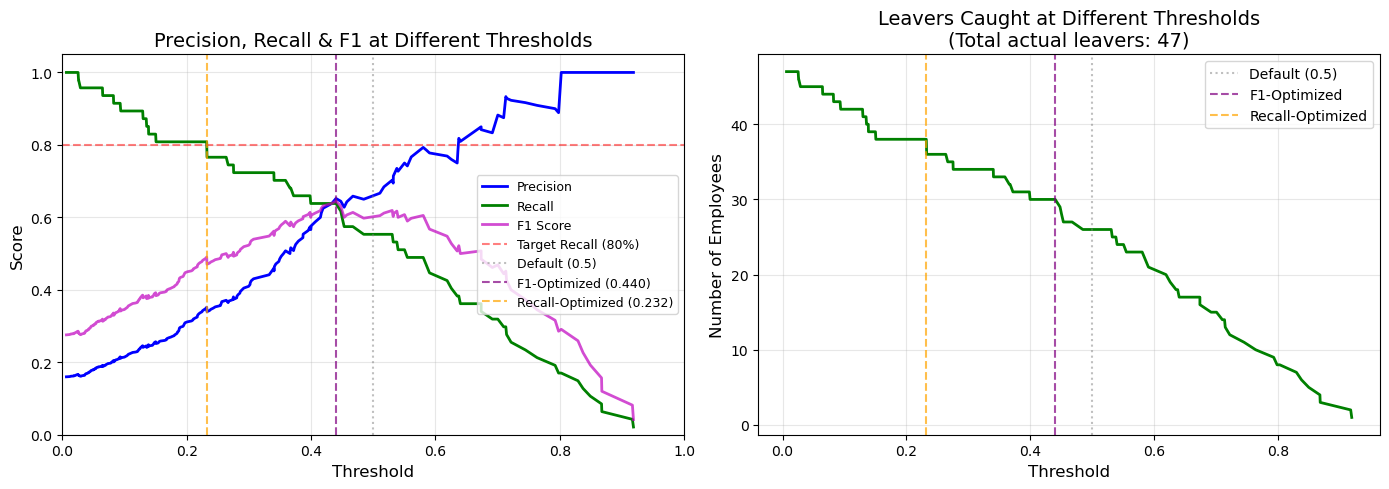

In [44]:
# ============================================================
# VISUALIZATION: Precision-Recall Trade-off by Threshold
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Precision and Recall vs Threshold
ax1 = axes[0]
ax1.plot(thresholds, precisions[:-1], 'b-', label='Precision', linewidth=2)
ax1.plot(thresholds, recalls[:-1], 'g-', label='Recall', linewidth=2)
ax1.plot(thresholds, f1_scores, 'm-', label='F1 Score', linewidth=2, alpha=0.7)
ax1.axhline(y=TARGET_RECALL, color='r', linestyle='--', alpha=0.5, 
            label=f'Target Recall ({TARGET_RECALL:.0%})')
ax1.axvline(x=0.5, color='gray', linestyle=':', alpha=0.5, label='Default (0.5)')
ax1.axvline(x=f1_optimal_threshold, color='purple', linestyle='--', alpha=0.7, 
            label=f'F1-Optimized ({f1_optimal_threshold:.3f})')
ax1.axvline(x=recall_optimal_threshold, color='orange', linestyle='--', alpha=0.7, 
            label=f'Recall-Optimized ({recall_optimal_threshold:.3f})')
ax1.set_xlabel('Threshold', fontsize=12)
ax1.set_ylabel('Score', fontsize=12)
ax1.set_title('Precision, Recall & F1 at Different Thresholds', fontsize=14)
ax1.legend(loc='center right', fontsize=9)
ax1.set_xlim([0, 1])
ax1.set_ylim([0, 1.05])
ax1.grid(True, alpha=0.3)

# Plot 2: Business Impact - Leavers caught at each threshold
ax2 = axes[1]
n_actual_leavers = y_val.sum()
leavers_caught = recalls[:-1] * n_actual_leavers

ax2.plot(thresholds, leavers_caught, 'g-', linewidth=2)
ax2.axvline(x=0.5, color='gray', linestyle=':', alpha=0.5, label='Default (0.5)')
ax2.axvline(x=f1_optimal_threshold, color='purple', linestyle='--', alpha=0.7,
            label=f'F1-Optimized')
ax2.axvline(x=recall_optimal_threshold, color='orange', linestyle='--', alpha=0.7,
            label=f'Recall-Optimized')
ax2.set_xlabel('Threshold', fontsize=12)
ax2.set_ylabel('Number of Employees', fontsize=12)
ax2.set_title(f'Leavers Caught at Different Thresholds\n(Total actual leavers: {n_actual_leavers:.0f})', fontsize=14)
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [45]:
# ============================================================
# VALIDATION SET EVALUATION - ALL THREE THRESHOLDS
# ============================================================

# Predictions with all three thresholds
y_val_pred_default = (y_val_proba >= 0.5).astype(int)
y_val_pred_f1 = (y_val_proba >= f1_optimal_threshold).astype(int)
y_val_pred_recall = (y_val_proba >= recall_optimal_threshold).astype(int)

print("=" * 60)
print("VALIDATION SET - DEFAULT THRESHOLD (0.5)")
print("=" * 60)
print(classification_report(y_val, y_val_pred_default, target_names=['Stay', 'Leave']))

print("=" * 60)
print(f"VALIDATION SET - F1-OPTIMIZED THRESHOLD ({f1_optimal_threshold:.3f})")
print("=" * 60)
print(classification_report(y_val, y_val_pred_f1, target_names=['Stay', 'Leave']))

print("=" * 60)
print(f"VALIDATION SET - RECALL-OPTIMIZED THRESHOLD ({recall_optimal_threshold:.3f})")
print("=" * 60)
print(classification_report(y_val, y_val_pred_recall, target_names=['Stay', 'Leave']))


VALIDATION SET - DEFAULT THRESHOLD (0.5)
              precision    recall  f1-score   support

        Stay       0.92      0.95      0.93       247
       Leave       0.67      0.55      0.60        47

    accuracy                           0.88       294
   macro avg       0.79      0.75      0.77       294
weighted avg       0.88      0.88      0.88       294

VALIDATION SET - F1-OPTIMIZED THRESHOLD (0.440)
              precision    recall  f1-score   support

        Stay       0.93      0.94      0.93       247
       Leave       0.65      0.64      0.65        47

    accuracy                           0.89       294
   macro avg       0.79      0.79      0.79       294
weighted avg       0.89      0.89      0.89       294

VALIDATION SET - RECALL-OPTIMIZED THRESHOLD (0.232)
              precision    recall  f1-score   support

        Stay       0.95      0.72      0.82       247
       Leave       0.35      0.81      0.49        47

    accuracy                           0.

In [46]:
# ============================================================
# TEST SET EVALUATION - ALL THREE THRESHOLDS
# ============================================================

# Get test predictions
y_test_proba = best_logreg.predict_proba(X_test)[:, 1]
y_test_pred_default = (y_test_proba >= 0.5).astype(int)
y_test_pred_f1 = (y_test_proba >= f1_optimal_threshold).astype(int)
y_test_pred_recall = (y_test_proba >= recall_optimal_threshold).astype(int)

print("=" * 60)
print("TEST SET - DEFAULT THRESHOLD (0.5)")
print("=" * 60)
print(classification_report(y_test, y_test_pred_default, target_names=['Stay', 'Leave']))

print("=" * 60)
print(f"TEST SET - F1-OPTIMIZED THRESHOLD ({f1_optimal_threshold:.3f})")
print("=" * 60)
print(classification_report(y_test, y_test_pred_f1, target_names=['Stay', 'Leave']))

print("=" * 60)
print(f"TEST SET - RECALL-OPTIMIZED THRESHOLD ({recall_optimal_threshold:.3f})")
print("=" * 60)
print(classification_report(y_test, y_test_pred_recall, target_names=['Stay', 'Leave']))

# Business metrics comparison
cm_default = confusion_matrix(y_test, y_test_pred_default)
cm_f1 = confusion_matrix(y_test, y_test_pred_f1)
cm_recall = confusion_matrix(y_test, y_test_pred_recall)

print("\n" + "=" * 75)
print("BUSINESS IMPACT COMPARISON - TEST SET")
print("=" * 75)
print(f"{'Metric':<30} {'Default':>12} {'F1-Opt':>12} {'Recall-Opt':>12}")
print("-" * 75)
print(f"{'Threshold':<30} {'0.500':>12} {f1_optimal_threshold:>12.3f} {recall_optimal_threshold:>12.3f}")
print(f"{'Leavers Caught (TP)':<30} {cm_default[1,1]:>12} {cm_f1[1,1]:>12} {cm_recall[1,1]:>12}")
print(f"{'Missed Departures (FN)':<30} {cm_default[1,0]:>12} {cm_f1[1,0]:>12} {cm_recall[1,0]:>12}")
print(f"{'False Alarms (FP)':<30} {cm_default[0,1]:>12} {cm_f1[0,1]:>12} {cm_recall[0,1]:>12}")
print(f"{'Correct Stay Predictions (TN)':<30} {cm_default[0,0]:>12} {cm_f1[0,0]:>12} {cm_recall[0,0]:>12}")
print("=" * 75)

# Calculate percentages
total_leavers = cm_default[1,0] + cm_default[1,1]
print(f"\n{'Recall (% Leavers Caught)':<30} {cm_default[1,1]/total_leavers:>11.1%} {cm_f1[1,1]/total_leavers:>12.1%} {cm_recall[1,1]/total_leavers:>12.1%}")
print(f"{'Precision (% Correct Flags)':<30} {cm_default[1,1]/(cm_default[1,1]+cm_default[0,1]):>11.1%} {cm_f1[1,1]/(cm_f1[1,1]+cm_f1[0,1]):>12.1%} {cm_recall[1,1]/(cm_recall[1,1]+cm_recall[0,1]):>12.1%}")


TEST SET - DEFAULT THRESHOLD (0.5)
              precision    recall  f1-score   support

        Stay       0.90      0.95      0.92       247
       Leave       0.63      0.47      0.54        47

    accuracy                           0.87       294
   macro avg       0.77      0.71      0.73       294
weighted avg       0.86      0.87      0.86       294

TEST SET - F1-OPTIMIZED THRESHOLD (0.440)
              precision    recall  f1-score   support

        Stay       0.91      0.89      0.90       247
       Leave       0.48      0.53      0.51        47

    accuracy                           0.83       294
   macro avg       0.69      0.71      0.70       294
weighted avg       0.84      0.83      0.84       294

TEST SET - RECALL-OPTIMIZED THRESHOLD (0.232)
              precision    recall  f1-score   support

        Stay       0.93      0.70      0.80       247
       Leave       0.31      0.72      0.44        47

    accuracy                           0.70       294
   ma

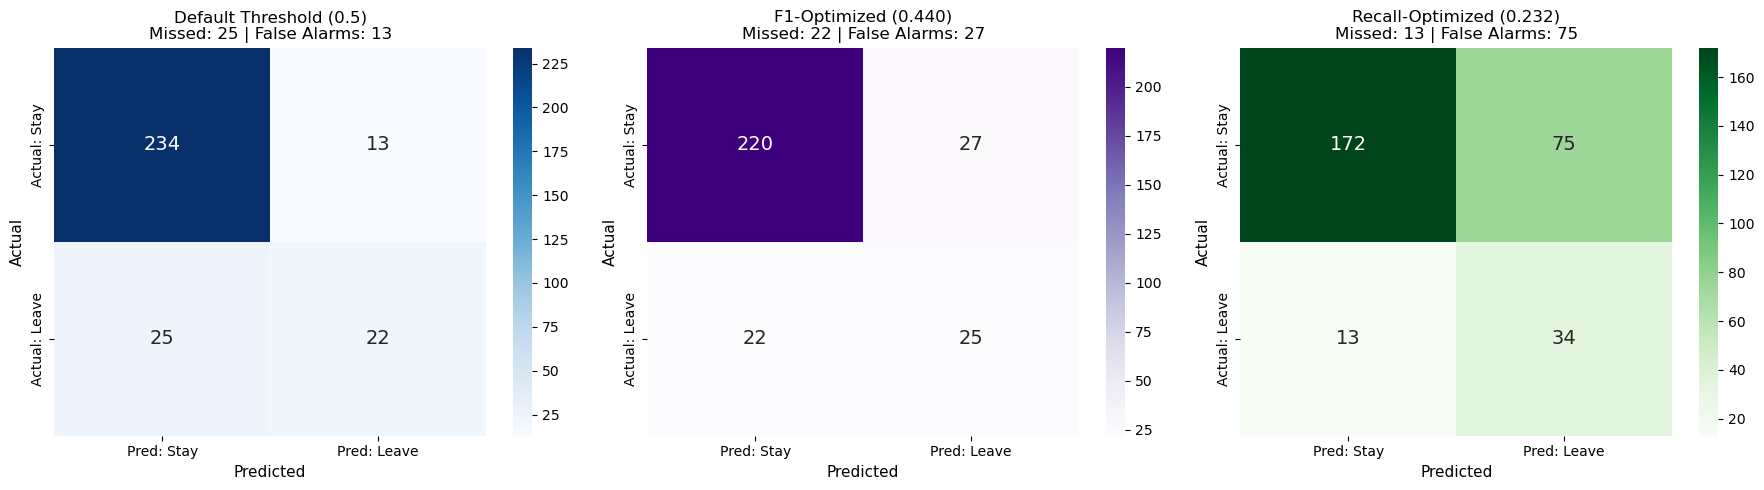

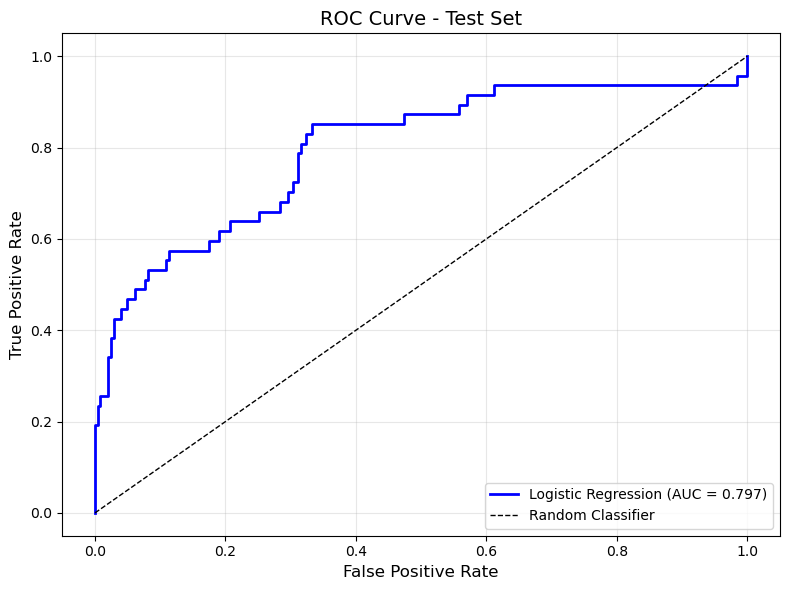

In [47]:
# ============================================================
# CONFUSION MATRICES: Default vs F1-Optimized vs Recall-Optimized
# ============================================================

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Default threshold
sns.heatmap(cm_default, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['Pred: Stay', 'Pred: Leave'],
            yticklabels=['Actual: Stay', 'Actual: Leave'],
            annot_kws={'size': 14})
axes[0].set_title(f'Default Threshold (0.5)\nMissed: {cm_default[1,0]} | False Alarms: {cm_default[0,1]}', fontsize=12)
axes[0].set_ylabel('Actual', fontsize=11)
axes[0].set_xlabel('Predicted', fontsize=11)

# F1-optimized threshold
sns.heatmap(cm_f1, annot=True, fmt='d', cmap='Purples', ax=axes[1],
            xticklabels=['Pred: Stay', 'Pred: Leave'],
            yticklabels=['Actual: Stay', 'Actual: Leave'],
            annot_kws={'size': 14})
axes[1].set_title(f'F1-Optimized ({f1_optimal_threshold:.3f})\nMissed: {cm_f1[1,0]} | False Alarms: {cm_f1[0,1]}', fontsize=12)
axes[1].set_ylabel('Actual', fontsize=11)
axes[1].set_xlabel('Predicted', fontsize=11)

# Recall-optimized threshold
sns.heatmap(cm_recall, annot=True, fmt='d', cmap='Greens', ax=axes[2],
            xticklabels=['Pred: Stay', 'Pred: Leave'],
            yticklabels=['Actual: Stay', 'Actual: Leave'],
            annot_kws={'size': 14})
axes[2].set_title(f'Recall-Optimized ({recall_optimal_threshold:.3f})\nMissed: {cm_recall[1,0]} | False Alarms: {cm_recall[0,1]}', fontsize=12)
axes[2].set_ylabel('Actual', fontsize=11)
axes[2].set_xlabel('Predicted', fontsize=11)

plt.tight_layout()
plt.show()

# ============================================================
# ROC CURVE
# ============================================================

from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, _ = roc_curve(y_test, y_test_proba)
auc_score = roc_auc_score(y_test, y_test_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, 'b-', linewidth=2, label=f'Logistic Regression (AUC = {auc_score:.3f})')
plt.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Test Set', fontsize=14)
plt.legend(loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()




--- Top 10 Most Important Features ---
                              feature  coefficient  abs_coefficient
9                TotalWorkingYearsLog    -0.843522         0.843522
11                       OverTime_Yes     0.809104         0.809104
5    BusinessTravel_Travel_Frequently     0.682357         0.682357
7   Department_Research & Development    -0.585745         0.585745
12      JobRole_Laboratory Technician     0.573108         0.573108
10               MaritalStatus_Single     0.560755         0.560755
18                Job_happiness_score    -0.398665         0.398665
16                 NumCompaniesWorked     0.390516         0.390516
3           JobRole_Research Director    -0.318784         0.318784
4        JobRole_Sales Representative     0.292629         0.292629


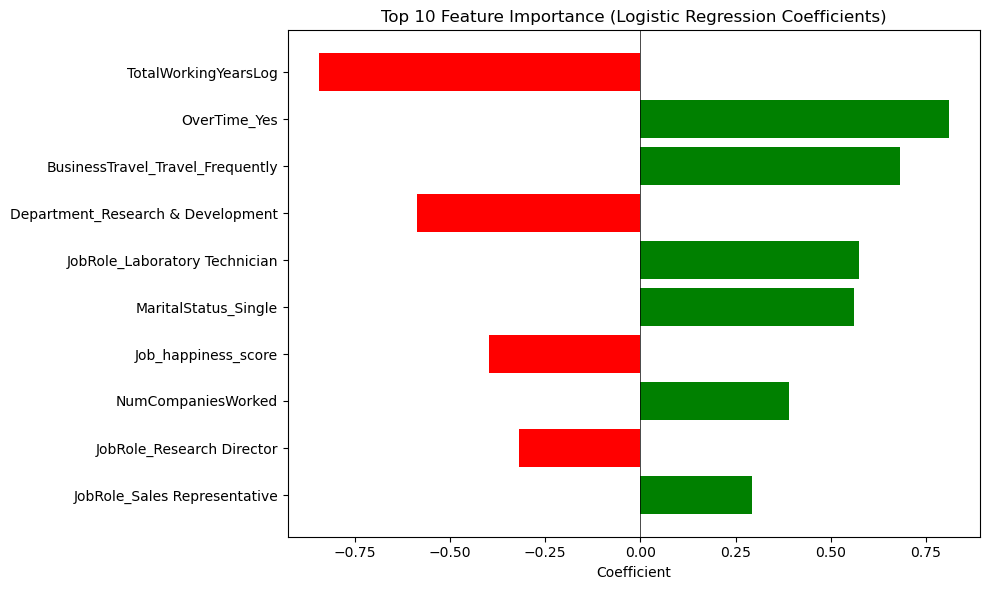

In [48]:
# Get feature importance from coefficients
feature_names = X_train.columns
coefficients = best_logreg.coef_[0]
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients,
    'abs_coefficient': np.abs(coefficients)
}).sort_values('abs_coefficient', ascending=False)

print("\n--- Top 10 Most Important Features ---")
print(feature_importance.head(10))

# Plot feature importance
plt.figure(figsize=(10, 6))
top_features = feature_importance.head(10)
colors = ['green' if c > 0 else 'red' for c in top_features['coefficient']]
plt.barh(top_features['feature'][::-1], top_features['coefficient'][::-1], color=colors[::-1])
plt.xlabel('Coefficient')
plt.title('Top 10 Feature Importance (Logistic Regression Coefficients)')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
plt.tight_layout()
plt.show()

In [49]:
MODEL_PATH = 'models'
os.makedirs(MODEL_PATH, exist_ok=True)
model_filename = os.path.join(MODEL_PATH, 'logistic_regression_best.pkl')
joblib.dump(best_logreg, model_filename)
print(f"Model saved to {model_filename}")


Model saved to models\logistic_regression_best.pkl


In [ ]:
'''
# Validation run logging
log_file_val = "logs/logreg_runs.json"
log_experiment(
    log_file=log_file_val,
    model_name="Logistic Regression (Validation)",
    variables=selected_features,
    params=grid_search.best_params_,
    metrics=val_metrics
)
print(f"Validation run logged to {log_file_val}")

# Test run logging
log_file_test = "logs/logreg_test_runs.json"
log_experiment(
    log_file=log_file_test,
    model_name="Logistic Regression (Test)",
    variables=selected_features,
    params=grid_search.best_params_,
    metrics=test_metrics
)
print(f"Test run logged to {log_file_test}")
'''